# NLP_GoingDeeper | PROJECT02. 뉴스카테고리 다중분류기 비교분석


---
**[ Introduce ]**
- 로이터(reuters) 뉴스 텍스트 데이터를 Bag of Words 가설을 기반으로 하는 **TF-IDF Vectorizing**전처리를 하고, **Machine Learning 모델**로 학습시킵니다.
- Machine Learning Model로는 CNB, 로지스틱 회귀, 그래디언트 부스팅 트리, 보팅을 활용하여 학습하고 성능을 비교분석합니다. 
- 이때, 데이터의 전처리는 모델의 성능에 직접적인 영향을 줍니다.
- 특히 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수는 성능에 큰 영향을 줄 수 있습니다. 
- 중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하거나, 반대로 너무 적은 단어들을 사용하게 되면 성능이 저하될 수 있으며, 이렇게 변화된 단어의 수는 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수 도 있습니다. 
- **따라서 단어의 수(Vocab size)에 따라서 머신러닝모델의 성능이 어떻게 변하는지 테스트합니다.**



    1. 모든 단어 사용 
        - (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
    
    
    2. 빈도수 상위 5,000개 사용
        - (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
    
    
    3. 직접 단어 개수 설정해서 최소 3가지 경우 이상 실험(10000개, 1000개)


- 위 과정을 통해 나온 최적의 모델과 단어 수 조건에서 LSTM 딥러닝 모델을 적용한 결과와 비교해보겠습니다. 
    - 공정한 비교를 위해 LSTM 모델의 입력으로 별다른 전처리 없이, padding 작업만 해서 넣어줍니다.  
    - 공정한 비교를 위해 Word2Vec 등 pretrained model은 사용하지 않습니다.


|평가문항|상세기준|
|--|--|
|분류 모델의 accuracy가 기준 이상 높게 나왔는가?|3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.|
|분류 모델의 F1 score가 기준 이상 높게 나왔는가?|Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.|
|딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?|동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.|

In [1]:
#- Data
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#- Vectorize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#- MachineLearning Model
from sklearn.naive_bayes import MultinomialNB #- 다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #- 정확도 계산

#- DeepLearning Model
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense
from keras.layers import Embedding, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

#- metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
def getData(vocab_size=None):

    #- Data Load
    (x_train,y_train),(x_test,y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)
    
    #- Vocabulary
    word_index = reuters.get_word_index(path = "reuters_word_index.json")
    index_to_word = {index+3: word for word,index in word_index.items()}
    
    #print(f"단어장의 크기는 {len(word_index)}입니다. 우리가 사용할 단어는 {num_words}개입니다. ")
    for index, token in enumerate(("<pad>","<sos>","<unk>")):
        index_to_word[index]=token 
    
    #- Sequence to text
    def decode(sequence):
        decoded = []
        for i in range(len(sequence)):
            t = ' '.join([index_to_word[index] for index in sequence[i]])
            decoded.append(t)
        return decoded

    de_x_train = decode(x_train) 
    de_x_test = decode(x_test)
    
    #- Vectorize (TF-IDF)
    dtmvector = CountVectorizer()
    tfidf_transformer = TfidfTransformer()
    
    x_train_dtm = dtmvector.fit_transform(de_x_train)
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    
    x_test_dtm = dtmvector.transform(de_x_test)
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)
    
    return x_train, y_train, x_test, y_test, tfidfv, tfidfv_test 


def check_data(x_train,x_test,y_train):
    
    #- 샘플 개수
    print('훈련 샘플의 수: {}'.format(len(x_train)))
    print('테스트 샘플의 수: {}'.format(len(x_test)))

    #- 클래스 개수
    num_classes = max(y_train)+1
    print('클래스의 수: {}'.format(num_classes))
    
    #- 길이분포
    print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
    print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len,x_train))/len(x_train)))
    plt.hist([len(s) for s in x_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
    #- 클래스 분포
    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    sns.countplot(x=y_train)
    plt.show()
    
    
def learnMLmodel(model, tfidfv, y_train, tfidfv_test, y_test):
    
    #- 학습
    model.fit(tfidfv, y_train) 
    
    #- 테스트 데이터에 대한 예측
    predicted = model.predict(tfidfv_test)
    
    #- 예측값과 실제값 비교
    accuracy = accuracy_score(y_test, predicted)
    print("\n%s 의 정확도는 %.4f 입니다."%(model,accuracy))
    
    # test_idx = int(input("몇 번째 샘플을 예측하길 원하시나요? : "))
    test_idx = 1
    test_txt = x_test[test_idx]
    real_label = y_test[test_idx]
    pred_label = model.predict(tfidfv_test[test_idx])
    if real_label == pred_label:
        print(f"정답입니다!!!\n실제값 : {real_label}\n예측값 : {pred_label}")
    else:
        print(f"오답입니다.\n실제값 : {real_label}\n예측값 : {pred_label}")
    
    probability = model.predict_proba(tfidfv_test[test_idx])[0]
    predProb(model, probability)
    
    return predicted


def predProb(model, probability):
    plt.rcParams["figure.figsize"] = (11,5)
    plt.bar(model.classes_, probability)
    plt.xlim(-1, 21)
    plt.xticks(model.classes_)
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.show()


def graph_confusion_matrix(model, x_test, y_test):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

- [분류 성능 평가](https://datascienceschool.net/03%20machine%20learning/09.04%20%EB%B6%84%EB%A5%98%20%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80.html)

# 1. 로이터 뉴스 데이터 로드
- 로이터 뉴스 데이터는 총 46개의 클래스로 구성되며, 해당 뉴스가 어느 카테고리에 속하는지를 예측하기 위한 데이터입니다.
- 텐서플로우 데이터셋에서 제공하고 있는 데이터로, 쉽게 다운로드가 가능합니다.
- num_words 는 이 데이터에서 빈도수 기준으로 상위 몇 번째 단어까지 사용할 것인지를 조절합니다. 각 단어는 고유한 번호가 정해져 있는 상태이고, 이를 통해서 사용할 단어의 수를 정합니다.
- 각 단어가 빈도수가 높은 순서대로 낮은 정수가 맵핑되어 있는데, 뉴스 데이터를 다운로드할 때는 단어가 아닌 해당 번호로 변환이 되어 출력됩니다.
- 텐서플로우 데이터셋에서는 이미 전처리를 한 데이터를 제공해주는 셈입니다.
- x_train과 x_test는 훈련용 뉴스 데이터와 테스트용 뉴스 데이터, y_train과 y_test는 훈련용 뉴스 데이터의 레이블과 테스트용 뉴스 데이터의 레이블입니다.
- 훈련용 뉴스는 8,982개, 그리고 테스트용 뉴스는 2,246개가 있습니다.
- 길이가 가장 긴 뉴스의 길이는 2,376이며, 평균 길이는 145입니다.
- 이 뉴스 데이터는 3, 4번 클래스가 대부분을 차지하고 있으며, 그 뒤로 19, 16, 1, 11번 등이 높은 분포를 가지고 있습니다.
- 수치적으로 살펴볼때, 3, 4번 클래스는 각 3,159개와 1,949개가 존재합니다. 그 뒤로는 549개로 19번 클래스가 세 번째로 많고, 16번 클래스가 444개로 네 번째로 많습니다.

## 1-1. 모든 단어 사용
- 30979개 단어를 사용합니다.  

In [3]:
x_train, y_train, x_test, y_test, tfidfv, tfidfv_test = getData()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수: 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


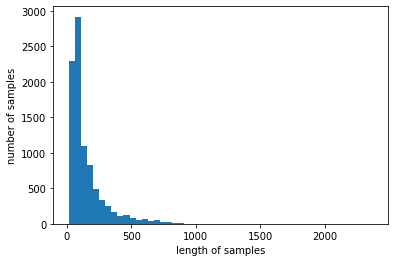

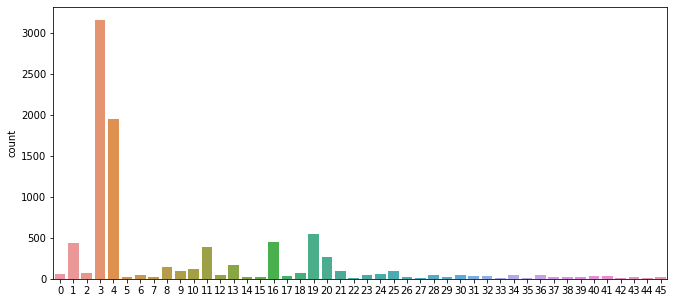

In [4]:
check_data(x_train,x_test,y_train)

- 데이터 불균형이란 어떤 데이터에서 각 클래스(주로 범주형 변수)가 갖고 있는 데이터의 양에 차이가 큰 경우입니다. 
- 위 reuter 클래스 빈도 그래프를 살펴보면, 총 46개의 클래스 중에서, 클래스 3,4의 빈도는 3000이 넘고 그 다음으로 빈도가 높은 19,1,11,16의 경우 약 500의 빈도를 보입니다. 그 외의 클래스들의 빈도는 200 미만으로, 데이터의 큰 불균형을 확인할 수 있습니다.  
- 따라서 성능평가 시, 데이터 불균형을 고려하지 않으면 정확한 평가가 불가능할 것으로 보입니다.
- 데이터가 불균형한 경우, accuracy값은 편향의 함정에 빠지게 될 수 있습니다.
- F1 score는 불균형 분류문제에서 평가척도로 주로 사용됩니다. 

### classification_report
- scikitlearn의 metrics 패키지에서는 정밀도, 재현율, F1 점수를 구하는 classification_report를 제공합니다. 
- 정확도(accuracy) : 전체 샘플 중 맞게 예측한 샘플 수의 비율으로, 높을 수록 좋은 모형입니다. 

$$accuracy= {𝑇𝑃+𝑇𝑁 \over 𝑇𝑃+𝑇𝑁+𝐹𝑃+𝐹𝑁}$$

- 정밀도(precision) : 양성(positive) 클래스에 속한다고 출력한 샘플 중 실제도 양성 클래스에 속하는 샘플 수의 비율으로, 높을 수록 좋은 모형입니다. 

$$precision={𝑇𝑃 \over 𝑇𝑃+𝐹𝑃}$$

- 재현률(recall) : 실제 양성 클래스에 속한 표본 중에 양성 클래스에 속한다고 출력한 표본의 수의 비율로, 높을 수록 좋은 모형입니다.

$$recall={𝑇𝑃 \over 𝑇𝑃+𝐹𝑁}$$

- 위양성율(fallout) : 실제 양성 클래스에 속하지 않는 표본 중에 양성 클래스에 속한다고 출력한 표본의 비율로, 낮을수록 좋은 모형입니다.

$$fallout={𝐹𝑃 \over 𝐹𝑃+𝑇𝑁}$$

- F점수(F-score) : 정밀도와 재현율의 가중조화평균(weight harmonic average)입니다. 정밀도에 주어지는 가중치를 beta라고 할 때, beta가 1인경우를 특별히 F1점수라고 합니다. 

$$𝐹𝛽={(1+𝛽^2)(precision×recall) \over (𝛽^2precision+recall)}$$
$$𝐹1={2⋅precision⋅recall \over (precision+recall)}$$

    - F1 score는 Sensitivity와 Precision의 값이 서로다른 형태를 나타내는 불균형 상태이지만, 이를 조화평균함으로써, 큰 값의 크기에 대한 가중치를 낮추고, 작은 값에 더 맞춰주는 과정을 거쳐서 값의 크기 차이를 어느정도 상쇄하게 됩니다. 
    - 예를들어, input class가 Positive에 맞춰져 있어, 모델이 긍정에 대한 예측이 강한 분류기로 만들어졌다고 할때, F1 Score 평가척도를 구해서 올바르게 분류가 되었는지 성능을 측정할 수 있는 것입니다. 
    
---

- micro: Calculate metrics globally by counting the total true positives, false negatives and false positives.
    -  각 클래스에 대한 TP/FP/FN을 합한 뒤에 f1-score를 계산합니다. 
- macro: Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    - 각 클래스에 따라 TP,FN,FP,TN값들을 이용해서 평가지표를 계산한 뒤 극 값들의 평균을 사용합니다. 
    - 각 레이블의 unweighted된 평균(레이블이 불균형한 멀티-클래스 분류 문제에서)을 계산합니다. 즉레이블의 불균형을 고려하지 않습니다.
    - 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가합니다. 따라서 가장 빈도 높은 클래스 레이블의 성능이 중요합니다.
- weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
    - 각 클래스에 해당하는 데이터 개수에 가중치를 두어 평균을 구합니다. 
    - 각 클래스에 대한 f1-score를 계산한 뒤 각 클래스 별 데이터 비율에 따른 가중 평균을 내어 f1-score를 계산합니다. 
    - 각 레이블이 불균형해도, weight를 주어 평가지표를 계산합니다.
- samples: Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score.
    
    - 각 레이블의 평가지표를 평균 냅니다.

## 1-2. 빈도수 상위 10,000개의 단어만 사용

In [5]:
x_train_10, y_train_10, x_test_10, y_test_10, tfidfv_10, tfidfv_test_10 = getData(10000)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## 1-3. 빈도수 상위 5,000개의 단어만 사용

In [6]:
x_train_5, y_train_5, x_test_5, y_test_5, tfidfv_5, tfidfv_test_5 = getData(5000)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## 1-4. 빈도수 상위 1000개의 단어만 사용

In [7]:
x_train_1, y_train_1, x_test_1, y_test_1, tfidfv_1, tfidfv_test_1 = getData(1000)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


# 2. 머신러닝 모델 훈련

In [8]:
#- Complement Naive Bayes Classifier
cb = ComplementNB()

#- Logistic Regression
lr = LogisticRegression(C=10000, penalty='l2')

#- Gradient Boosting Classifier
grbt = GradientBoostingClassifier(random_state=0) #- verbose=3

#- soft voting
voting_classifier = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=10000, penalty='l2')),
    ('cb', ComplementNB()),
    ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)

## 2-1. 모든 단어 사용

In [9]:
# predicted = learnMLmodel(cb, tfidfv, y_train, tfidfv_test, y_test)
# print(classification_report(y_test, predicted, zero_division=0))
# # graph_confusion_matrix(cb, x_test, y_test)

In [10]:
# predicted = learnMLmodel(lr, tfidfv, y_train, tfidfv_test, y_test)
# print(classification_report(y_test, predicted, zero_division=0))
# # graph_confusion_matrix(lr, x_test, y_test)

In [11]:
# predicted = learnMLmodel(grbt, tfidfv, y_train, tfidfv_test, y_test)
# print(classification_report(y_test, predicted, zero_division=0))
# # graph_confusion_matrix(grbt, x_test, y_test)

In [12]:
# predicted = learnMLmodel(voting_classifier, tfidfv, y_train, tfidfv_test, y_test)
# print(classification_report(y_test, predicted, zero_division=0))
# # graph_confusion_matrix(voting_classifier, x_test, y_test)

## 2-2. 빈도수 상위 10000개의 단어만 사용


ComplementNB() 의 정확도는 0.7707 입니다.
정답입니다!!!
실제값 : 10
예측값 : [10]


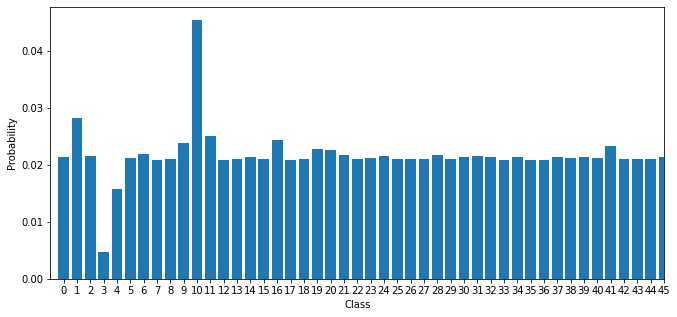

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.64      0.88      0.74       105
           2       0.91      0.50      0.65        20
           3       0.91      0.89      0.90       813
           4       0.75      0.92      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.50      0.13      0.21        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.55      0.73      0.63        83
          12       0.00      0.00      0.00        13
          13       0.58      0.59      0.59        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.67      0.79      0.73        99
          17       0.00    

In [13]:
predicted = learnMLmodel(cb, tfidfv_10, y_train_10, tfidfv_test_10, y_test_10)
print(classification_report(y_test_10, predicted, zero_division=0))
# graph_confusion_matrix(cb, x_test_10, y_test_10)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



LogisticRegression(C=10000) 의 정확도는 0.8077 입니다.
정답입니다!!!
실제값 : 10
예측값 : [10]


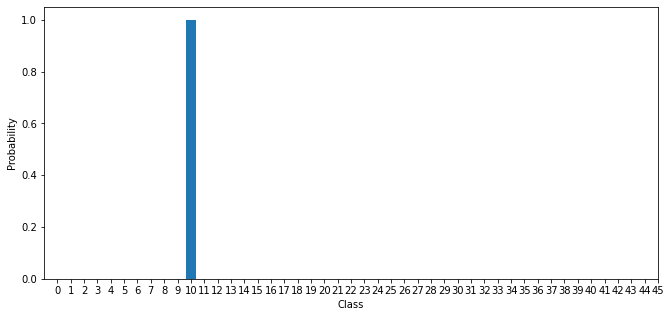

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.78      0.76       105
           2       0.74      0.85      0.79        20
           3       0.92      0.93      0.93       813
           4       0.81      0.87      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.68      0.71      0.69        38
           9       0.81      0.84      0.82        25
          10       0.93      0.87      0.90        30
          11       0.64      0.73      0.68        83
          12       0.57      0.31      0.40        13
          13       0.59      0.59      0.59        37
          14       0.50      0.50      0.50         2
          15       0.67      0.44      0.53         9
          16       0.68      0.75      0.71        99
          17       0.75    

In [14]:
predicted = learnMLmodel(lr, tfidfv_10, y_train_10, tfidfv_test_10, y_test_10)
print(classification_report(y_test_10, predicted, zero_division=0))
# graph_confusion_matrix(lr, x_test_10, y_test_10)


GradientBoostingClassifier(random_state=0) 의 정확도는 0.7667 입니다.
정답입니다!!!
실제값 : 10
예측값 : [10]


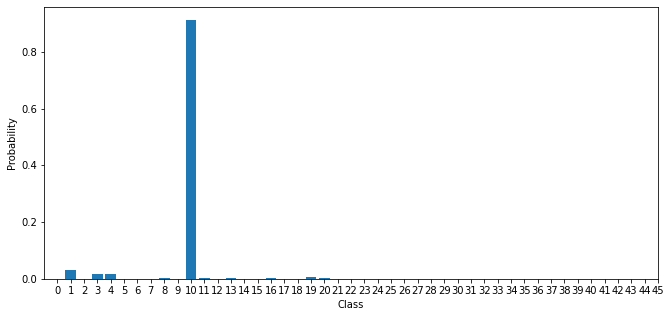

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.77      0.68      0.72       105
           2       0.78      0.70      0.74        20
           3       0.88      0.91      0.89       813
           4       0.76      0.83      0.79       474
           5       0.50      0.20      0.29         5
           6       0.80      0.86      0.83        14
           7       1.00      0.33      0.50         3
           8       0.64      0.66      0.65        38
           9       0.74      0.80      0.77        25
          10       0.90      0.87      0.88        30
          11       0.63      0.64      0.63        83
          12       0.33      0.46      0.39        13
          13       0.62      0.49      0.55        37
          14       0.14      0.50      0.22         2
          15       0.38      0.33      0.35         9
          16       0.73      0.73      0.73        99
          17       0.27    

In [15]:
predicted = learnMLmodel(grbt, tfidfv_10, y_train_10, tfidfv_test_10, y_test_10)
print(classification_report(y_test_10, predicted, zero_division=0))
# graph_confusion_matrix(grbt, x_test_10, y_test_10)


VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft') 의 정확도는 0.8117 입니다.
정답입니다!!!
실제값 : 10
예측값 : [10]


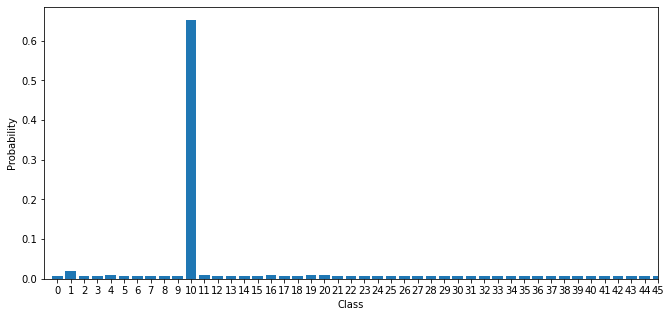

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.77      0.74      0.76       105
           2       0.73      0.80      0.76        20
           3       0.92      0.94      0.93       813
           4       0.83      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.70      0.68      0.69        38
           9       0.81      0.84      0.82        25
          10       0.93      0.90      0.92        30
          11       0.65      0.69      0.67        83
          12       0.46      0.46      0.46        13
          13       0.68      0.62      0.65        37
          14       0.14      0.50      0.22         2
          15       0.57      0.44      0.50         9
          16       0.72      0.75      0.73        99
          17       0.53    

In [16]:
predicted = learnMLmodel(voting_classifier, tfidfv_10, y_train_10, tfidfv_test_10, y_test_10)
print(classification_report(y_test_10, predicted, zero_division=0))
# graph_confusion_matrix(voting_classifier, x_test_10, y_test_10)

## 2-3. 빈도수 상위 5,000개의 단어만 사용

In [17]:
# predicted = learnMLmodel(cb, tfidfv_5, y_train_5, tfidfv_test_5, y_test_5)
# print(classification_report(y_test_5, predicted, zero_division=0))
# # graph_confusion_matrix(cb, x_test_5, y_test_5)

In [18]:
# predicted = learnMLmodel(lr, tfidfv_5, y_train_5, tfidfv_test_5, y_test_5)
# print(classification_report(y_test_5, predicted, zero_division=0))
# # graph_confusion_matrix(lr, x_test_5, y_test_5)

In [19]:
# predicted = learnMLmodel(grbt, tfidfv_5, y_train_5, tfidfv_test_5, y_test_5)
# print(classification_report(y_test_5, predicted, zero_division=0))
# # graph_confusion_matrix(grbt, x_test_5, y_test_5)

In [20]:
# predicted = learnMLmodel(voting_classifier, tfidfv_5, y_train_5, tfidfv_test_5, y_test_5)
# print(classification_report(y_test_5, predicted, zero_division=0))
# # graph_confusion_matrix(voting_classifier, x_test_5, y_test_5)

## 2-4. 빈도수 상위 1,000개의 단어만 사용

In [21]:
# predicted = learnMLmodel(cb, tfidfv_1, y_train_1, tfidfv_test_1, y_test_1)
# print(classification_report(y_test_1, predicted, zero_division=0))
# # graph_confusion_matrix(cb, x_test_1, y_test_1)

In [22]:
# predicted = learnMLmodel(lr, tfidfv_1, y_train_1, tfidfv_test_1, y_test_1)
# print(classification_report(y_test_1, predicted, zero_division=0))
# # graph_confusion_matrix(lr, x_test_1, y_test_1)

In [23]:
# predicted = learnMLmodel(grbt, tfidfv_1, y_train_1, tfidfv_test_1, y_test_1)
# print(classification_report(y_test_1, predicted, zero_division=0))
# # graph_confusion_matrix(grbt, x_test_1, y_test_1)

In [24]:
# predicted = learnMLmodel(voting_classifier, tfidfv_1, y_train_1, tfidfv_test_1, y_test_1)
# print(classification_report(y_test_1, predicted, zero_division=0))
# # graph_confusion_matrix(voting_classifier, x_test_1, y_test_1)

# 3. 머신러닝 성능 비교분석

## 3-1. 모든 단어
|model|accuracy|f1-score(accuracy/macro avg/weighted avg)|
|--|--|--|
|Complement Naive Bayes Classifier|0.7649|0.76/0.46/0.73|
|Logistic Regression|0.8134|0.81/0.67/0.81|
|Gradient Boosting Classifier|0.7703|0.77/0.57/0.76|
|soft voting|0.8188|0.82/0.66/0.81|

## 3-2. 빈도수 상위 10000개
|model|accuracy|f1-score(accuracy/macro avg/weighted avg)|
|--|--|--|
|Complement Naive Bayes Classifier|0.7707|0.77/0.48/0.75|
|Logistic Regression|0.8077|0.81/0.64/0.77|
|Gradient Boosting Classifier|0.7667|0.77/0.58/0.76|
|soft voting|0.8117|0.81/ 0.66/0.81|

## 3-3. 빈도수 상위 5000개
|model|accuracy|f1-score(accuracy/macro avg/weighted avg)|
|--|--|--|
|Complement Naive Bayes Classifier|0.7707|0.77/0.48/0.75|
|Logistic Regression|0.8059|0.81/0.64/0.80|
|Gradient Boosting Classifier|0.7676|0.77/0.58/0.77|
|soft voting|0.8161|0.82/0.66/0.81|

## 3-4. 빈도수 상위 1000개
|model|accuracy|f1-score(accuracy/macro avg/weighted avg)|
|--|--|--|
|Complement Naive Bayes Classifier|0.7346|0.73/0.29/0.70|
|Logistic Regression|0.7801|0.78/0.56/0.77|
|Gradient Boosting Classifier|0.7458|0.75/0.42/0.74|
|soft voting|0.7845|0.78/0.50/0.78|

- 로이터 뉴스 데이터는 불균형한 클래스를 가집니다.
- label이 불균형한 경우에는 단순히 accuracy 값을 비교하는 것으로는 부족하며, f1-score를 통해 성능을 정확하게 분석할 수 있습니다.
- 최종 결과에서 각각이 의미하는 바는 다음과 같습니다.
    - macro : 단순평균
    - weighted : 각 클래스에 속하는 표본의 개수로 가중평균
    - accuracy : 정확도, 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율
- 우선, 모든 단어수 항목의 머신러닝 모델 중에서 soft voting이 가장 높은 성능을 보이고 있습니다.
- soft voting 모델은 complement naive bayes, Logistic, Gradient Boosting 모델을 활용했습니다.
- 1000개 단어장 이외의 '모든 단어, 1000개, 5000개'에서 soft voting 모델은 비슷한 성능을 보입니다. 
- 모든 단어를 활용했을 때, f1-score(accuracy/macro avg/weighted avg) = 0.82/0.66/0.81 입니다.

# 4. LSTM 딥러닝 학습
- 데이터의 빈도수 상위 10,000개 단어를 단어장으로 설정했습니다. 
- 위 머신러닝 학습과 비교분석하기 위해, 별다른 전처리 없이 maxlen = 200으로 패딩 작업만 하여 입력값으로 넣어주었습니다.

In [25]:
def LSTM(x_train, y_train, x_test, y_test, max_len=200, vocab_size=5000, word_vector_dim=128):
    
    x_train = pad_sequences(x_train, maxlen=max_len, padding='pre') # 훈련용 뉴스 기사 패딩
    x_test = pad_sequences(x_test, maxlen=max_len, padding='pre') # 테스트용 뉴스 기사 패딩
    
    y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
    y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩
    
    partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)
    
    model_lstm = keras.Sequential()
    model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim))
    model_lstm.add(keras.layers.LSTM(128))   
    model_lstm.add(keras.layers.Dropout(0.1))
    model_lstm.add(keras.layers.Dense(46, activation='softmax')) 

    model_lstm.summary()
   
    
    early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    model_lstm.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history_lstm = model_lstm.fit(partial_x_train,
                        partial_y_train,
                        epochs=15,
                        batch_size=128,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, mc])
    
    history_lstm_dict = history_lstm.history
    model_results = model_lstm.evaluate(x_test, y_test, verbose=2)
    return history_lstm_dict, model_results


def plot_history(vocab_size, history_dict):
    train_acc = history_dict['accuracy']
    train_loss = history_dict['loss']
    val_acc = history_dict['val_accuracy']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, train_acc)
    plt.plot(epochs, val_loss)
    plt.plot(epochs, val_acc)
    plt.legend(['train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'],loc='center right')
    plt.title(f'LSTM_vocabsize={vocab_size}')
    plt.show()

In [26]:
total_data_text = list(x_train) + list(x_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  145.96419665122906
문장길이 최대 :  2376
문장길이 표준편차 :  145.8784764459447
pad_sequences maxlen :  437
전체 문장의 0.9438902743142145%가 maxlen 설정값 이내에 포함됩니다. 


In [27]:
history_lstm_dict, model_results = LSTM(x_train_10, y_train_10, x_test_10, y_test_10, 200, 10000,128)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 46)                5934      
Total params: 1,417,518
Trainable params: 1,417,518
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
57/57 [==============================] - 7s 71ms/step - loss: 3.0525 - accuracy: 0.3136 - val_loss: 2.3105 - val_accuracy: 0.3628

Epoch 00001: val_accuracy improved from -inf to 0.36283, saving model to best_model.h5
Epoch 2/15
57/5

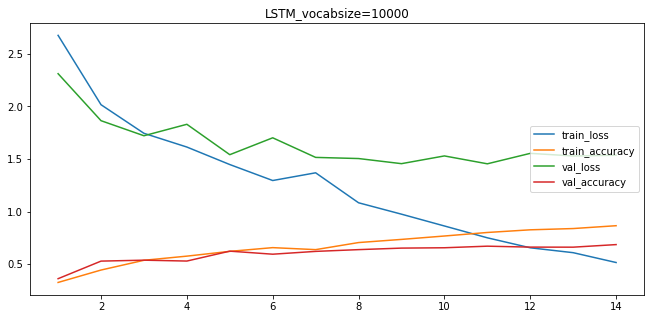

In [28]:
plot_history(10000, history_lstm_dict)

In [29]:
model_results

[1.6249498128890991, 0.6696348786354065]

# 5. 결과 분석

- vocab_size=1000의 TF-IDF matrix를 입력으로 하여 LSTM모델에  실험을 해보았습니다. 
- 아래 이미지와 같이 전혀, 학습되지 않는 모습을 볼 수 있습니다.
- sparse 하며 데이터의 크기가 너무 커서, vocab_size를 10,000으로 할 경우, 아예 학습이 진행되지 않았습니다.  
- accuracy는 0.05, loss는 -5000에 가까워지는 것을 확인할 수 있습니다. 
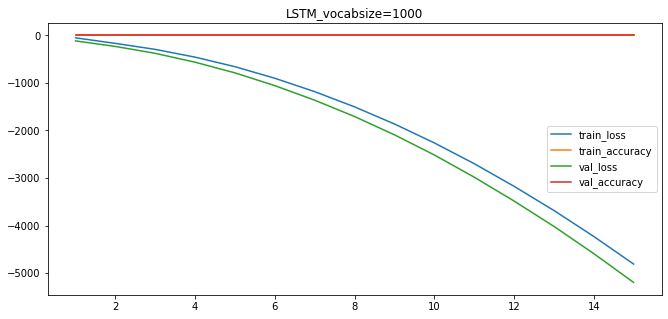

- LSTM의 입력으로 별다른 전처리 없이 maxlen=200 으로 padding 한 sequence를 넣었습니다. 
- LSTM의 학습결과, loss: 1.6249 - accuracy: 0.6696 입니다.
- Machine Learning voting model, f1-score weighted avg는 0.81 입니다.
- 무조건 딥러닝 모델이 머신러닝 모델보다 더욱 성능이 좋은 것은 아니며, 데이터의 특성과 전처리 방법에 따라 적절한 모델로 학습해야한다는 것을 알 수 있습니다. 
- 머신러닝 모델 중에서는 soft voting 모델이 가장 좋은 성능을 보였습니다.
- '백지장도 맞들면 낫다'는 속담이 있듯이 여러 모델의 결과물을 활용하는 것이 앙상블 기법의 비결입니다.